<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
from ipywidgets import IntProgress
from IPython.display import display,HTML,clear_output
import random
import time
import math
from math import radians, sin, cos, sqrt
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from uits3_krakow22.src.Event import Event
from uits3_krakow22.src.Cluster import Cluster
from uits3_krakow22.src.Track import Track
from uits3_krakow22.src.Vertex import Vertex
from uits3_krakow22.src.Utils import *
from skspatial.plotting import plot_3d
from skspatial.objects import Points, Cylinder, Plane
from IPython.display import Image

display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>table {float:left;}</style>"))

Welcome to JupyROOT 6.24/06


In [3]:
class Fiber:
    def __init__(self,center=[0,0,0],radius=1,height=10):
        self.center = center
        self.radius = radius
        self.height = height
    
    def getRandomPoint(self):
        R = random.random()*self.radius
        height = (random.random()-0.5)*self.height
        theta = random.random()*2*math.pi
        coordinate = [self.center[0]+R*math.cos(theta),self.center[1]+height,self.center[2]+R*math.sin(theta)]
        return coordinate
class ALPIDECylinder:
    def __init__(self, p1, p2, radius):
        self.p1 = np.array(p1)
        self.p2 = np.array(p2)
        self.radius = radius
        self.center = (self.p1 + self.p2) / 2

[[0, 0, -16.83], [0, 0, -18.562050807568877], [-0.25, 0, -18.129038105676656], [0.25, 0, -18.129038105676656], [-0.5, 0, -17.696025403784436], [0, 0, -17.696025403784436], [0.5, 0, -17.696025403784436], [-0.75, 0, -17.26301270189222], [-0.25, 0, -17.26301270189222], [0.25, 0, -17.26301270189222], [0.75, 0, -17.26301270189222]]


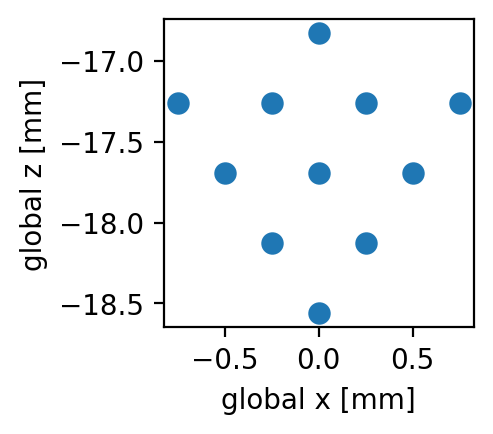

In [4]:
dist = 0.5 #spacing between fibers
#define arrays of coordinates for the center of each fiber
origin = [[0,0,0]] 
row1 = [[0,0,-2*dist*math.sqrt(3)]]
row2 = [[-dist*0.5,0,-dist*(3*math.sqrt(3)/2)],[dist*0.5,0,-dist*(3*math.sqrt(3)/2)]]
row3 = [[-dist,0,-dist*math.sqrt(3)],[0,0,-dist*math.sqrt(3)],[dist,0,-dist*math.sqrt(3)]]
row4 = [[-dist*1.5,0,-dist*math.sqrt(3)/2],[-dist*0.5,0,-dist*math.sqrt(3)/2],[dist*0.5,0,-dist*math.sqrt(3)/2],[dist*1.5,0,-dist*math.sqrt(3)/2]]
centers = origin + row1 + row2 + row3 + row4

for center in centers:
    center[2] = center[2]-16.83
print(centers)

fig = plt.figure(figsize=(2, 2), dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel("global x [mm]")
ax.set_ylabel("global z [mm]")
points = Points([[center[0],center[2]] for center in centers])
#plane = Plane.from_points(points[0],points[1],points[2])
#plane.plot_3d(ax, alpha=0.2)
points.plot_2d(ax, s=50)

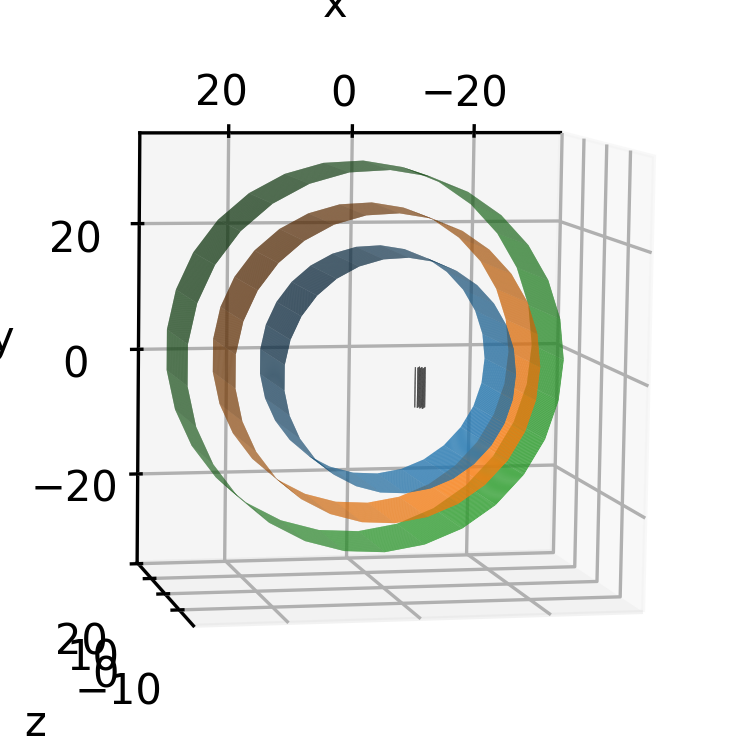

In [5]:
save = False
cylinders = [Cylinder([center[0],center[1]-3,center[2]],[0,6,0],0.075) for center in centers] #defines the fibers
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.set_proj_type('ortho')
ax.view_init(-75,30,60)
for target in cylinders: #each target fiber is added
    target.plot_3d(ax,color="grey",alpha=1)
    
ALPIDE_0 = Cylinder([0,0,12.5-7.5], [0,0,15], 30)
ALPIDE_1 = Cylinder([0,0,6.25-7.5], [0,0,15], 24)
ALPIDE_2 = Cylinder([0,0,0-7.5], [0,0,15], 18)

ALPIDE_2.plot_3d(ax, alpha=1)
ALPIDE_1.plot_3d(ax, alpha=1)
ALPIDE_0.plot_3d(ax, alpha=1)

viewingAngles = [[0,0],[0,-90],[90,-90],[30,-55]]
if save:
    for [angle1,angle2] in viewingAngles:
        ax.view_init(angle1, angle2)
        plt.savefig("targets"+str(angle1)+"_"+str(angle2)+".png",bbox_inches='tight')

In [6]:
openingAngle = (87.08/360)*2*math.pi #200MeV
#fiber = Fiber(center=[0,0,18.75],height=6,radius=0.075)
fibers = [Fiber(center=center,height=6,radius=0.075) for center in centers]
events = []
reps = 1#000
for i in range(reps):
    fiber = random.choice(fibers)
    phi = (random.random()-0.5)*math.pi * 0.265258238 #Berkin says this is the "wobble DoF"
    theta = openingAngle/2
    shift = (random.random()-0.5)*0.3
    
    origin = fiber.getRandomPoint()
    #origin = [0,-18.75,0]
    trackLeft = Track(point= origin,
                      vector=[math.sin(phi+shift)*math.cos(theta), math.cos(phi+shift), math.sin(phi+shift)*math.sin(theta)])
    #trackLeftScattered = trackLeft.get
    trackRight = Track(point=origin,
                      vector=[math.sin(-phi+shift)*math.cos(theta), math.cos(-phi+shift), math.sin(-phi+shift)*math.sin(theta)])
    event = Event(tracks=[trackLeft,trackRight])
    events.append(event)
    print(trackLeft.point, trackLeft.vector)
    print(trackRight.point, trackRight.vector)

[0.2615941104622986, -1.259168765076485, -18.072319211325805] [0.20720436236499284, 0.958277042332656, 0.19690470374039784]
[0.2615941104622986, -1.259168765076485, -18.072319211325805] [-0.03366300108997209, 0.9989211490956061, -0.03198968970043998]


# Calculate Expected DCA and Track RMS

Total events  11450 out of  100000  fraction  0.1145
DCA Values:  13.350071922690375  um
Missed  88550


<Figure size 640x480 with 0 Axes>

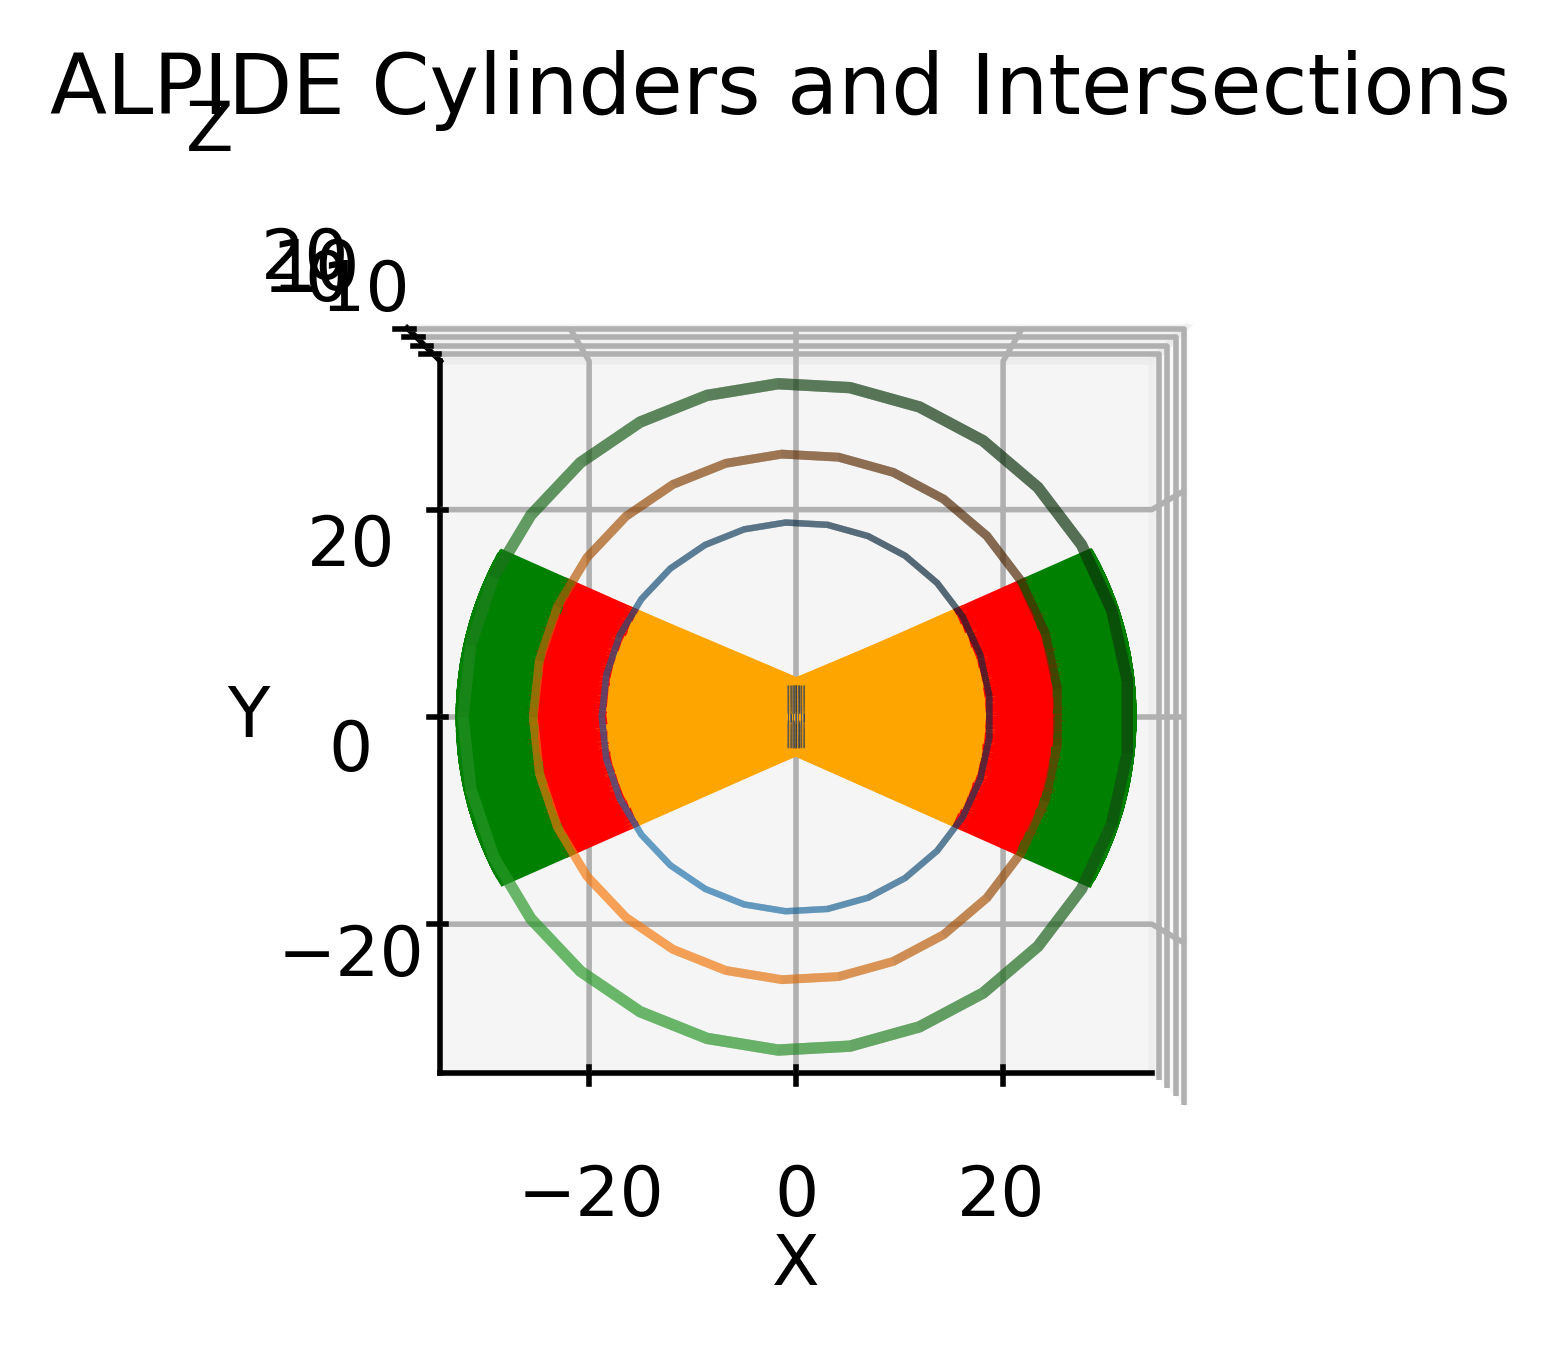

Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DCA cluster (Potential memory leak).


In [20]:
cALPIDE_0 = ALPIDECylinder([0,0,12.5-7.5], [0,0,15], 30)
cALPIDE_1 = ALPIDECylinder([0,0,6.25-7.5], [0,0,15], 24)
cALPIDE_2 = ALPIDECylinder([0,0,0-7.5], [0,0,15], 18)

def intersects_cylinder(cylinder, p1, p2):
    radius = cylinder.radius
    
    # Extract coordinates of the two points
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector of the line
    direction = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    # Vector from the cylinder center to the starting point of the line
    start_to_center = np.array([x1, y1, 0])
    
    # Calculate the coefficients for the quadratic equation
    a = np.dot(direction[:2], direction[:2])
    b = 2 * np.dot(start_to_center[:2], direction[:2])
    c = np.dot(start_to_center[:2], start_to_center[:2]) - radius**2
    
    # Solve the quadratic equation
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        return []  # No intersection
    
    t1 = (-b + np.sqrt(discriminant)) / (2 * a)
    t2 = (-b - np.sqrt(discriminant)) / (2 * a)
    
    # Calculate intersection points
    intersection1 = np.array([x1, y1, z1]) + t1 * direction
    intersection2 = np.array([x1, y1, z1]) + t2 * direction
    
    
    # Check if the intersection points are within the height range of the cylinder
    inters=0
    intersections = []
    if cylinder.p1[2] <= intersection1[2] <= cylinder.p2[2]:
        intersections.append(intersection1)
        inters+=1
    if cylinder.p1[2] <= intersection2[2] <= cylinder.p2[2]:
        intersections.append(intersection2)
        inters+=1
    #print('Intersections:', inters)
    #print(np.sqrt(intersection1[0]**2  + intersection1[1]**2))
    #print(np.sqrt(intersection2[0]**2  + intersection2[1]**2))
    return intersections
    

def rotate_vector(vector, axis, angle):
    axis = axis / np.linalg.norm(axis)
    a = cos(angle / 2.0)
    b, c, d = -axis * sin(angle / 2.0)
    rotation_matrix = np.array([[a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
                                [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
                                [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]])
    return np.dot(rotation_matrix, vector)

def perturb_line_slope(line_coords, scattering_angle_radians, printing):
    # Extract coordinates
    x, y, z, x2, y2, z2 = line_coords #represent point on target and point on ALPIDE 2
    
    # Calculate the original direction vector of the line from target to point on ALPIDE 2
    dx = x2 - x
    dy = y2 - y
    dz = z2 - z
    original_direction = np.array([dx, dy, dz])
    intersection_points_ALPIDE_2 = np.array(intersects_cylinder(cALPIDE_2, np.array(line_coords[0:3]),np.array(line_coords[3:6])))    
   
    if not np.any(intersection_points_ALPIDE_2):
        if printing: print('No ALPIDE 2 Intercept')
        return 1    
  
    x2, y2, z2 = intersection_points_ALPIDE_2[0]
       
    # Calculate random scattering wit sigma from scattering_angle_radians
    def scattering_angle_radians_random(scattering_angle_radians=scattering_angle_radians):
        return scattering_angle_radians * np.random.randn()
    
    # Calculate the initial intersection with ALPIDE1
    intersection_points_ALPIDE_1 = intersects_cylinder(cALPIDE_1, np.array([x, y, z]), np.array([x2, y2, z2]))

    if not np.any(intersection_points_ALPIDE_1):
        if printing: print('No ALPIDE 1 Intercept')
        return 1  
    x1, y1, z1 = intersection_points_ALPIDE_1[0]
   
    # Generate random azimuth angles for scattering off the first two ALPIDEs
    azimuth_ALPIDE2_radians = np.random.uniform(0, 2 * np.pi)
    azimuth_ALPIDE1_radians = np.random.uniform(0, 2 * np.pi)

    # Perturb the line slope between ALPIDE 2 and 1
    axis_ALPIDE2 = np.array([cos(azimuth_ALPIDE2_radians), sin(azimuth_ALPIDE2_radians), 0])
    #chose the random azimuth for the scattering angle
    perturbed_direction1 = rotate_vector(np.array([x1 - x2, y1 - y2, z1 - z2]), axis_ALPIDE2, scattering_angle_radians_random())

    # Calculate new 3D coordinates for the second point based on the perturbed direction
    # Might have to be added but i think this is the wrong sort of factor 
    x1_new = x1 + perturbed_direction1[0]
    y1_new = y1 + perturbed_direction1[1]
    z1_new = z1 + perturbed_direction1[2]

    intersection_points_ALPIDE_1 = intersects_cylinder(cALPIDE_1, np.array([x2, y2, z2]), np.array([x1_new, y1_new, z1_new]))
    
    if not np.any(intersection_points_ALPIDE_1):
        if printing: print('No ALPIDE 1 Intercept')
        return 1
    
    # Calculate the initial intersection with ALPIDE0 using vector from previous collision
    intersection_points_ALPIDE_0 = intersects_cylinder(cALPIDE_0, np.array([x2, y2, z2]), np.array([x1_new, y1_new, z1_new]))
    
    if not np.any(intersection_points_ALPIDE_0):
        if printing: print('No ALPIDE 0 Intercept')
        return 1
    x0, y0, z0 = intersection_points_ALPIDE_0[0]
   
    # Perturb the line slope between ALPIDE 1 and 0
    axis_ALPIDE1 = np.array([cos(azimuth_ALPIDE1_radians), sin(azimuth_ALPIDE1_radians), 0])
    perturbed_direction0 = rotate_vector(np.array([x0 - x1, y0 - y1, z0 - z1]), axis_ALPIDE1, scattering_angle_radians_random())

    
    # Calculate new 3D coordinates for the second point based on the perturbed direction
    x0_new = x0 + perturbed_direction0[0]
    y0_new = y0 + perturbed_direction0[1]
    z0_new = z0 + perturbed_direction0[2]

    intersection_points_ALPIDE_0 = intersects_cylinder(cALPIDE_0,intersection_points_ALPIDE_1[0], np.array([x0_new, y0_new, z0_new]))
    
    if not np.any(intersection_points_ALPIDE_0):
        if printing: print('No ALPIDE 0 Intercept')
        return 1

    return x2, y2, z2, *intersection_points_ALPIDE_1[0], *intersection_points_ALPIDE_0[0]

def plot_cylinder(cylinder, ax, color):
    # Plot the cylinder as a vertical line between the two points p1 and p2
    #ax.plot([cylinder.p1[0], cylinder.p2[0]], [cylinder.p1[1], cylinder.p2[1]], [cylinder.p1[2], cylinder.p2[2]], color='blue')
    # Plot the circular top face of the cylinder
    t = np.linspace(0, 2*np.pi, 100)
    x_circle = cylinder.radius * np.cos(t) + cylinder.p1[0]
    y_circle = cylinder.radius * np.sin(t) + cylinder.p1[1]
    z_circle = np.full_like(t, cylinder.p1[2])
    ax.plot(x_circle, y_circle, z_circle, color=color)
    # Plot the circular bottom face of the cylinder
    x_circle = cylinder.radius * np.cos(t) + cylinder.p2[0]
    y_circle = cylinder.radius * np.sin(t) + cylinder.p2[1]
    z_circle = np.full_like(t, cylinder.p2[2])
    ax.plot(x_circle, y_circle, z_circle, color=color)

def plot_line(line_coords, ax, color):
    #print("linecoords ", line_coords)
    ax.plot([line_coords[0], line_coords[3]], [line_coords[1], line_coords[4]], [line_coords[2], line_coords[5]], color=color)
    
#def main():
%jsroot on
hVertexXY = ROOT.TH2F("VertexXY","VertexXY",200,-7,7,200,-7,7)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",200,-5,5,200,-23,-15)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",200,-7,7,200,-26,-12)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hDCA = ROOT.TH1F("DCA cluster","DCA Cluster",22*10,-0.1,1000.1)
hDCA.GetXaxis().SetTitle("DCA [um]")
hDCA.GetYaxis().SetTitle("Count")

printing = False
# Create a 3D plot
fig = plt.figure()
save = False
cylinders = [Cylinder([center[0],center[1]-3,center[2]],[0,6,0],0.075) for center in centers] #defines the fibers
fig = plt.figure(figsize=(3, 3), dpi=500)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(80,10,100)
ax.view_init(90,0,90)

for target in cylinders: #each target fiber is added
    target.plot_3d(ax,color="grey",alpha=1)

ALPIDE_2.plot_3d(ax, alpha=1)
ALPIDE_1.plot_3d(ax, alpha=1)
ALPIDE_0.plot_3d(ax, alpha=1)

scattering_angle_radians = 1.32/1000 #*10# Fixed scattering angle in radians   check with berkin that i should not divide by /2.355. but if thet0 is sigma then shouldnt it be *2/2.355? Check with berkin and try this next!
#line_coords = (-0.003376, 1.232, -16.775, 20.272, -11.495, 4.487)  # Example line 
#Have to start a loop here that generates reps number of left and right tracks, we only select events which pass through all ALPIDEs
#here a random origin is generated:
reps = 100000
numEvents=0
events=[]
dcaVals=[]
openingAngle = (87.08/360)*2*math.pi #200MeV
missed =0
for i in range(reps):
    fiber = random.choice(fibers)
    phi = openingAngle/2
    shift = (random.random()-0.5)*0.3
    theta = (random.random()-0.5)*math.pi*0.265258238
    origin = fiber.getRandomPoint()

    trackLeft = Track(point= origin, vector=[math.sin(phi+shift)*math.cos(theta), math.sin(phi+shift)*math.sin(theta), math.cos(phi+shift)])
    trackRight = Track(point=origin,vector=[math.sin(-phi+shift)*math.cos(theta), math.sin(-phi+shift)*math.sin(theta), math.cos(-phi+shift)])

    event = Event(tracks=[trackLeft,trackRight]) #this event may be useful to compare no scattering case with multiple scattering
    events.append(event) 

    line_coords_left = (*trackLeft.point, *ALPIDE_2.intersect_line(trackLeft.line)[0])
    line_coords_right = (*trackRight.point, *ALPIDE_2.intersect_line(trackRight.line)[0])

    new_line_coords_left = perturb_line_slope(line_coords_left, scattering_angle_radians, printing)
    new_line_coords_right = perturb_line_slope(line_coords_right, scattering_angle_radians, printing)

    if new_line_coords_left == 1:
        if printing: print('Missing left intersection')
    #    return 0
        missed+=1
    elif new_line_coords_right == 1:
        if printing: print('Missing right intersection')
        missed+=1
    else:
        numEvents+=1
        x,y,z = line_coords_left[0:3]         
        x2, y2, z2 = np.array(intersects_cylinder(cALPIDE_2, np.array(line_coords_left[0:3]),np.array(line_coords_left[3:6]))[0])
        x3, y3, z3 = np.array(intersects_cylinder(cALPIDE_2, np.array(line_coords_right[0:3]),np.array(line_coords_right[3:6]))[0])        
        # Plot the line segments
        plot_line([x,y,z, x2, y2, z2], ax, color = 'orange') #should be line from origin to ALPIDE2 left
        plot_line([x,y,z, x3, y3, z3], ax, color = 'orange') #should be line from origin to ALPIDE2 right

        colors = ['red', 'green', 'blue']
        cyls = [cALPIDE_2,cALPIDE_1,cALPIDE_0]


        trackRight = Track()
        trackLeft  = Track()
        rightArr = []
        leftArr = []

        for layer in range(3): #plot ALPIDEs, scattered lines to ALPIDEs, and the intersections
            #plot_cylinder(cyls[layer], ax, colors[layer])
            #ax.scatter(new_line_coords_left[layer*3:layer*3+3], color = colors[layer], marker='o')


            clusterLeft = Cluster()
            clusterRight = Cluster()
            clusterLeft.globalPos = [*new_line_coords_left[layer*3:layer*3+3]]
            if layer !=1:
                clusterRight.globalPos = [*new_line_coords_right[layer*3:layer*3+3]]
                rightArr.append(clusterRight)
            leftArr.append(clusterLeft)
            if i%10000: 
                #print(np.sqrt(new_line_coords_left[layer*3]**2  + new_line_coords_left[layer*3 + 1]**2))
                #print(np.sqrt(new_line_coords_right[layer*3]**2 + new_line_coords_right[layer*3 + 1]**2))                
                if layer <2:
                    plot_line(new_line_coords_left[layer*3:layer*3+6], ax, colors[layer])
                    plot_line(new_line_coords_right[layer*3:layer*3+6], ax, colors[layer])

        trackRight.fromClusters(rightArr)
        trackLeft.fromClusters(leftArr)

        vertex = Vertex()
        vertex.fromTracks([trackLeft,trackRight])
        dcaVals.append(vertex.dca)
        hDCA.Fill(vertex.dca*1000)
        hVertexXY.Fill(vertex.point[0],vertex.point[1])
        hVertexXZ.Fill(vertex.point[0],vertex.point[2])
        hVertexYZ.Fill(vertex.point[1],vertex.point[2])


print('Total events ', numEvents, 'out of ', reps, ' fraction ', numEvents/reps)        
print('DCA Values: ', np.mean(dcaVals)*1000, ' um')
print('Missed ', missed)
if printing:
    print('line_coords: ', line_coords)
    print("New line coordinates:", new_line_coords)
    print("Intersections with ALPIDE_2:", new_line_coords[:3])
    print("Intersections with ALPIDE_1:", new_line_coords[3:6])
    print("Intersections with ALPIDE_0:", new_line_coords[6:9])


viewingAngles = [[0,0],[0,-90],[90,-90],[-30,55]]
if save:
    for [angle1,angle2] in viewingAngles:
        ax.view_init(angle1, angle2)
        plt.savefig("multScat"+str(angle1)+"_"+str(angle2)+".png",bbox_inches='tight')

# Set labels and show the plot  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('ALPIDE Cylinders and Intersections')
plt.show()



canvas = ROOT.TCanvas("", "", 800, 800)
canvas.Divide(2, 2)  # Divide the canvas into two rows and two columns

# First panel (row 1, column 1)
canvas.cd(1)
ROOT.gPad.SetGrid(2)
hVertexXY.Draw("COLZ")

# Second panel (row 1, column 2)
canvas.cd(2)
ROOT.gPad.SetGrid(2)
hVertexXZ.Draw("COLZ")

# Third panel (row 2, column 1)
canvas.cd(3)
ROOT.gPad.SetGrid(2)
hVertexYZ.Draw("COLZ")

# Fourth panel (row 2, column 2)
canvas.cd(4)
ROOT.gPad.SetGrid(2)
hDCA.Draw()

# Draw the canvas
canvas.Draw()

#canvas.Print("root_plots.png")  # Save the ROOT plots as an image

# Display both plots
#display(Image("root_plots.png"))
    
#if __name__ == "__main__":
#    main()

## nBins = {"x-Axis" : 1500, "y-Axis" : 750}


In [7]:
nRange = {"x-Axis" : 16, "y-Axis" : 8}
axis = {"x-Axis":0, "y-Axis":1}

axesComb = [["x-Axis","x-Axis"],["x-Axis","y-Axis"],["y-Axis","y-Axis"]]
#axesComb = [["x-Axis","y-Axis"]]

In [8]:
%jsroot on
canvas = ROOT.TCanvas("myCanvas","myCanvas",1000,1000)
legend = ROOT.TLegend()

detector1 = "ALPIDE_0"
detector2 = "ALPIDE_4"

for [axis1,axis2] in axesComb:
    # Calculate histogram
    hCorr = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"Correlation_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2, nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
    hCorr.SetXTitle(detector1 + " - " + axis1)
    hCorr.SetYTitle(detector2 + " - " + axis2)
    for event in events:
        clustersDetector1 = event.selectDetector(detector1)
        clustersDetector2 = event.selectDetector(detector2)
        #if len(clustersDetector1) == 1 and len(clustersDetector2) == 1:
        if True:
            for cluster1 in clustersDetector1:
                if cluster1.isClusterIn():
                    for cluster2 in clustersDetector2:
                        if cluster2.isClusterIn():
                            hCorr.Fill(cluster1.localPos[axis.get(axis1)],cluster2.localPos[axis.get(axis2)])

    #Draw histogram
    hCorr.Draw("COLZ")
    canvas.Draw()
    #canvas.SaveAs("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2+"_all_targets.png")

NameError: name 'nBins' is not defined

In [ ]:
%jsroot on
nBins = {"x-Axis" : 300, "y-Axis" : 150}
nRange = {"x-Axis" : 15, "y-Axis" : 7.5}
axis = {"x-Axis":0, "y-Axis":1}
detector1 = "ALPIDE_2"
detector2 = "ALPIDE_2"
detector3 = "ALPIDE_1"
detector4 = "ALPIDE_1"
axis1="x-Axis"!

axis2="y-Axis"
axis3="x-Axis"
axis4="y-Axis"
lowerClustSizThresh = 7  #thresholds for how big to make the file for analysis
upperClustSizThresh = 15
clustNumThresh = 1
hCorr = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"Correlation of "+detector1+" with "+detector3, nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
hCorr.SetXTitle(axis1 + " / mm")
hCorr.SetYTitle(axis2 + " / mm")
for event in events:
    clustersDetector1 = event.selectDetector(detector1)
    clustersDetector2 = event.selectDetector(detector2)
    clustersDetector3 = event.selectDetector(detector3)
    clustersDetector4 = event.selectDetector(detector4)
    for cluster1 in clustersDetector1:
        for cluster2 in clustersDetector2:
            for cluster3 in clustersDetector3:
                for cluster4 in clustersDetector4:
                    hCorr.Fill(cluster1.localPos[axis.get(axis1)]-cluster3.localPos[axis.get(axis3)],cluster2.localPos[axis.get(axis2)]-cluster4.localPos[axis.get(axis4)])
canvas = ROOT.TCanvas()
hCorr.Draw("COLZ")
canvas.Draw()